## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [12]:
import string
import os
import re
import requests

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from random import sample
import time

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [13]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [14]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
str = "";
for i in range(len(text)):
    str = str + text[i]

text = str.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [16]:
tmp = []
for i in range(0, len(text)):
    tmp.append(text[i].lower())

text = tmp

text = ''.join(text)
parts = re.split('\n\n\s*[a-z]*\n\n', text)

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [19]:
text = ''.join(line.lower() for line in text)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [20]:
parts = re.split(r'\n\n\s*[a-z]*\n\n', text)

In [21]:
tokens = sorted(set(text))
print(tokens)

print(len(tokens))

['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [22]:
token_to_idx = {}
idx_to_token = {}

for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i;
    idx_to_token[i] = tokens[i];
    
num_tokens = len(tokens)
num_tokens

38

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [23]:
def to_matrix(parts, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    # Определяем максимальную длину строки: max_len или длина самой длинной строки в parts
    max_len = max_len or max(map(len, parts))
    
    # Создаем матрицу parts_ix размером [количество строк, max_len], заполняем ее значением паддинга (pad)
    parts_ix = np.zeros([len(parts), max_len], dtype) + pad

    # Проходим по каждой строке в parts
    for i in range(len(parts)):
        # Преобразуем строку в список индексов символов, используя словарь token_to_idx
        line_ix = [token_to_idx[c] for c in parts[i]]
        
        # Копируем индексы строки в соответствующую строку матрицы parts_ix
        # Обрезаем или дополняем строку до max_len
        parts_ix[i, :len(line_ix)] = line_ix

    # Если параметр batch_first=False, транспонируем матрицу, чтобы строки стали столбцами
    if not batch_first:
        parts_ix = np.transpose(parts_ix)

    # Возвращаем итоговую матрицу
    return parts_ix

In [24]:
batch_ix = to_matrix(parts[:5])
print(batch_ix)

[[ 1  1 17 ...  1  1  1]
 [ 1  1 34 ... 23 15  8]
 [ 1  1 23 ...  1  1  1]
 [ 1  1 32 ...  1  1  1]
 [ 1  1 31 ...  1  1  1]]


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [25]:
# Your code here

class CharRNNCell(nn.Module):
    """
    Реализация RNN ячейки для работы с последовательностями символов.
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
    
        super(self.__class__, self).__init__()  # Инициализация базового класса nn.Module
        self.num_units = rnn_num_units  # Сохраняем количество нейронов в скрытом состоянии
        
        # Определяем слой эмбеддингов: сопоставляет каждому символу вектор из embedding_size
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        
        # Определяем линейный слой для обновления скрытого состояния RNN
        # Принимает на вход объединенный вектор эмбеддингов (embedding_size) и скрытого состояния (rnn_num_units)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        
        # Определяем линейный слой для преобразования скрытого состояния в логиты (предсказания вероятностей)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_prev):
     
        # Преобразуем токены в их эмбеддинги, размерность [batch_size, embedding_size]
        x_emb = self.embedding(x)
        
        # Объединяем эмбеддинги текущего символа и скрытое состояние
        # Размерность объединённого вектора: [batch_size, embedding_size + rnn_num_units]
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        
        # Обновляем скрытое состояние RNN через линейный слой
        h_next = self.rnn_update(x_and_h)
        
        # Применяем функцию активации tanh для ограничения значений скрытого состояния
        h_next = torch.tanh(h_next)
      
        # Преобразуем новое скрытое состояние в логиты для предсказания следующего символа
        logits = self.rnn_to_logits(h_next)
        
        # Возвращаем новое скрытое состояние и логарифмы вероятностей (log_softmax)
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)


In [26]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

def rnn_loop(char_rnn, batch_ix):
    # Определяем размер батча и длину последовательности
    batch_size, max_length = batch_ix.size()

    # Инициализируем скрытое состояние RNN размером [batch_size, rnn_num_units], заполненное нулями
    hid_state = char_rnn.initial_state(batch_size)

    # Список для сохранения логарифмов вероятностей на каждом шаге
    logprobs = []

    # Цикл по каждому временному шагу
    # Используем .transpose(0,1), чтобы сделать последовательности главным измерением (размер [max_length, batch_size])
    for x_t in batch_ix.transpose(0, 1):
        # Применяем RNN к текущему токену x_t и предыдущему скрытому состоянию hid_state
        # hid_state: новое скрытое состояние
        # logp_next: логарифмы вероятностей для следующего символа
        hid_state, logp_next = char_rnn(x_t, hid_state)

        # Сохраняем логарифмы вероятностей для текущего временного шага
        logprobs.append(logp_next)

    # Объединяем список logprobs в один тензор размером [max_length, batch_size, num_tokens],
    # затем транспонируем обратно в [batch_size, max_length, num_tokens]
    return torch.stack(logprobs, dim=1)


Plot the loss function (axis X: number of epochs, axis Y: loss function).

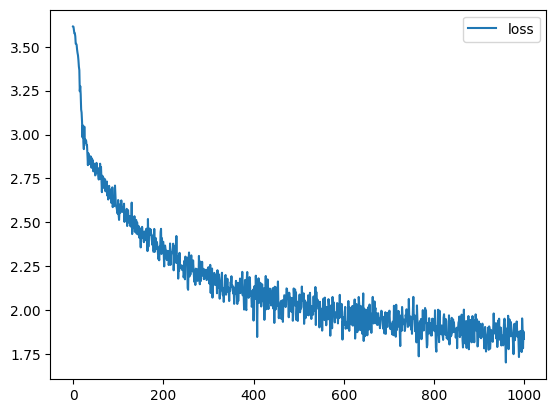

In [27]:
# Создаем экземпляр CharRNNCell — это наша RNN ячейка
char_rnn = CharRNNCell()

# Определяем функцию потерь: Negative Log-Likelihood Loss (NLLLoss), подходит для задачи классификации
criterion = nn.NLLLoss()

# Создаем оптимизатор Adam, который будет обновлять параметры RNN
opt = torch.optim.Adam(char_rnn.parameters())

# Инициализируем список для хранения значений функции потерь на каждом шаге обучения
history = []

# Основной цикл обучения, 1000 итераций
for i in range(1000):
    # Получаем батч данных: выбираем 2 случайные последовательности из parts
    batch_ix = to_matrix(sample(parts, 2))
    
    # Преобразуем батч в тензор типа int64, чтобы он подходил для работы с RNN
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    # Прогоняем текущий батч через RNN
    # logp_seq — логарифмы вероятностей предсказанных токенов
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # Вычисляем предсказания (логарифмы вероятностей) для всех токенов, кроме последнего
    # Размерность predictions_logp: [batch_size, max_length-1, num_tokens]
    predictions_logp = logp_seq[:, :-1]
    
    # Реальные значения следующих токенов (целевые значения)
    # Размерность actual_next_tokens: [batch_size, max_length-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    # Вычисляем функцию потерь (loss)
    # Преобразуем predictions_logp и actual_next_tokens в векторы для NLLLoss
    # predictions_logp.view(-1, num_tokens): [batch_size * (max_length-1), num_tokens]
    # actual_next_tokens.view(-1): [batch_size * (max_length-1)]
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # Вычисляем градиенты по функции потерь
    loss.backward()

    # Обновляем параметры RNN с помощью оптимизатора Adam
    opt.step()
    
    # Обнуляем градиенты перед следующей итерацией
    opt.zero_grad()
    
    # Сохраняем значение функции потерь в истории для последующего анализа
    history.append(loss.data.numpy())

    # Каждые 100 итераций обновляем график функции потерь
    if (i+1) % 100 == 0:
        clear_output(True)  # Очищаем вывод, чтобы обновить график
        plt.plot(history, label='loss')  # Строим график функции потерь
        plt.legend()  # Добавляем легенду
        plt.show()  # Показываем график


In [28]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=1000, temperature=1.0):
    """
    Функция для генерации текста с использованием RNN.
    """
    # Преобразуем символы начальной фразы в индексы
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64).unsqueeze(0)  # Размерность [1, seq_length]
    hid_state = char_rnn.initial_state(batch_size=1)  # Инициализируем скрытое состояние

    # Прогоняем seed_phrase через модель (без генерации новых токенов)
    for i in range(len(seed_phrase) - 1):
        token = x_sequence[:, i]  # Размерность [1]
        hid_state, _ = char_rnn(token, hid_state)

    # Начинаем генерацию текста
    for _ in range(max_length - len(seed_phrase)):
        token = x_sequence[:, -1]  # Размерность [1]
        hid_state, logits = char_rnn(token, hid_state)

        # Применяем softmax с температурой для получения вероятностей
        probabilities = F.softmax(logits / temperature, dim=-1).squeeze(0).detach().numpy()

        # Сэмплируем следующий токен на основе вероятностей
        next_idx = np.random.choice(len(tokens), p=probabilities)

        # Добавляем индекс следующего токена в последовательность
        next_idx_tensor = torch.tensor([[next_idx]], dtype=torch.int64)  # Размерность [1, 1]
        x_sequence = torch.cat([x_sequence, next_idx_tensor], dim=1)

    # Преобразуем последовательность индексов обратно в символы
    generated_text = ''.join([tokens[idx] for idx in x_sequence.squeeze(0).tolist()])
    return generated_text


In [29]:
for _ in range(4):
    print(generate_sample(char_rnn, seed_phrase="stars", temperature=0.8))
    print('\n\n')

wheny cand to henst bes migh's in thou so no my coudst nor wirgery from ppache that now the me ingeds of then bang sind e thel
  besings therer,
  ronk wite thip thou prall of of the ratl's me thy soud will cound and,
  that shenceelisk dese trme thing tey w'est thal frime:
  toar to the if ghy sear.
    thy of nor hose.
  the beert fame the rith willy thou mis thinctout tou graturelm bearnem,
  whor eld my hons;
  of craver, my mis than grose prenptersele my that a to wiche,
  as on be sey shing owe,
  on purly brigot seess and of nesory exerut bets for wiwh bo of thy slevere;
  senvere not that dey world for and werter of is with   to stantss peid would word.
  ahe lover the fos poras mabes cold exe the then the my live, haigimy in thy see, bein with dath on iy thy dith as as il thy stad upar gard thk i celloptare dot tind i  urat will thach thy thy doth of my gleds thou freines stant bed then beough
    gouth thet bun thene,
  that thee he prowr wertoretibe prowen thel were not famy

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [33]:
class CharLSTMCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=16, lstm_num_units=64):

        super(self.__class__, self).__init__()
        self.num_units = lstm_num_units  # Сохраняем количество нейронов в скрытом состоянии

        # Слой эмбеддингов: преобразует токены в вектора фиксированного размера
        self.embedding = nn.Embedding(num_tokens, embedding_size)

        # LSTM ячейка: обрабатывает эмбеддинги и скрытые состояния
        self.lstm_cell = nn.LSTMCell(embedding_size, lstm_num_units)

        # Линейный слой для предсказания логитов (вероятностей)
        self.lstm_to_logits = nn.Linear(lstm_num_units, num_tokens)

    def forward(self, x, h_prev, c_prev):
        # Преобразуем входной токен в эмбеддинг
        x_emb = self.embedding(x)

        # Обновляем скрытое состояние и состояние памяти
        h_next, c_next = self.lstm_cell(x_emb, (h_prev, c_prev))

        # Преобразуем скрытое состояние в логиты (предсказания)
        logits = self.lstm_to_logits(h_next)

        # Возвращаем новое состояние и логарифмы вероятностей
        return h_next, c_next, F.log_softmax(logits, dim=-1)

    def initial_state(self, batch_size):
        h = torch.zeros(batch_size, self.num_units, requires_grad=True)
        c = torch.zeros(batch_size, self.num_units, requires_grad=True)
        return h, c


In [34]:
def lstm_loop(char_lstm, batch_ix):
    # Определяем размер батча и длину последовательности
    batch_size, max_length = batch_ix.size()

    # Инициализация скрытых состояний (нулевые значения)
    h_state, c_state = char_lstm.initial_state(batch_size)

    # Список для хранения логарифмов вероятностей
    logprobs = []

    # Цикл по каждому временному шагу
    for x_t in batch_ix.transpose(0, 1):
        # Обновляем скрытые состояния и получаем логарифмы вероятностей
        h_state, c_state, logp_next = char_lstm(x_t, h_state, c_state)

        # Сохраняем логарифмы вероятностей
        logprobs.append(logp_next)

    # Преобразуем список в тензор
    return torch.stack(logprobs, dim=1)


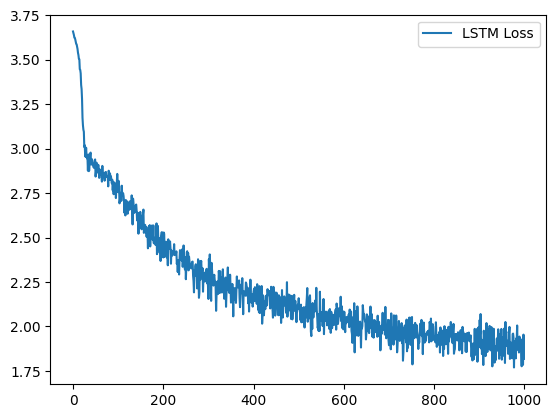

In [35]:
char_lstm = CharLSTMCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_lstm.parameters())

history_lstm = []

# Основной цикл обучения
for i in range(1000):
    # Выбираем случайный батч из данных
    batch_ix = to_matrix(sample(parts, 2))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    # Прогоняем данные через LSTM
    logp_seq = lstm_loop(char_lstm, batch_ix)

    # Выделяем предсказания и целевые значения
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    # Вычисляем функцию потерь
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # Шаг оптимизации
    loss.backward()
    opt.step()
    opt.zero_grad()

    # Сохраняем значение функции потерь
    history_lstm.append(loss.data.numpy())

    # Каждые 100 шагов обновляем график
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history_lstm, label='LSTM Loss')
        plt.legend()
        plt.show()


Plot the loss function of the number of epochs. Does the final loss become better?

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [36]:
# Text generation with different temperature values here
def generate_sample_lstm(char_lstm, seed_phrase=' Hello', max_length=1000, temperature=1.0):
    # Преобразуем начальную фразу в индексы
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64).unsqueeze(0)

    # Инициализируем скрытые состояния
    h_state, c_state = char_lstm.initial_state(batch_size=1)

    # Пропускаем начальную фразу через модель
    for i in range(len(seed_phrase) - 1):
        token = x_sequence[:, i]
        h_state, c_state, _ = char_lstm(token, h_state, c_state)

    # Генерация текста
    for _ in range(max_length - len(seed_phrase)):
        token = x_sequence[:, -1]
        h_state, c_state, logits = char_lstm(token, h_state, c_state)

        # Применяем Softmax с температурой
        probabilities = F.softmax(logits / temperature, dim=-1).squeeze(0).detach().numpy()

        # Сэмплируем следующий токен
        next_idx = np.random.choice(len(tokens), p=probabilities)

        # Добавляем новый токен в последовательность
        next_idx_tensor = torch.tensor([[next_idx]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_idx_tensor], dim=1)

    # Преобразуем последовательность индексов обратно в текст
    generated_text = ''.join([tokens[idx] for idx in x_sequence.squeeze(0).tolist()])
    return generated_text


In [37]:
for temp in [0.1, 0.2, 0.5, 0.8, 1.0, 1.5]:
    print(f"Температура: {temp}")
    print(generate_sample_lstm(char_lstm, seed_phrase="stars", temperature=temp))
    print("\n" + "="*50 + "\n")

Температура: 0.1
wheng                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [42]:
# Сохранение обученной модели LSTM
torch.save(char_lstm.state_dict(), "lstm.pth")
print("Model saved to char_lstm.pth")

Model saved to char_lstm.pth


In [43]:
# Загрузка ранее сохраненной модели
loaded_char_lstm = CharLSTMCell()  # Создаем новую модель
loaded_char_lstm.load_state_dict(torch.load("lstm.pth"))  # Загружаем веса
loaded_char_lstm.eval()  # Переводим модель в режим оценки
print("Model loaded successfully.")

Model loaded successfully.


In [44]:
# Генерация текста с использованием загруженной модели
seed_phrase = "stars"  # Начальная фраза для генерации текста
temperature = 0.5  # Температура для контроля случайности
max_length = 100  # Максимальная длина генерируемого текста

generated_text = generate_sample_lstm(loaded_char_lstm, seed_phrase=seed_phrase, temperature=temperature, max_length=max_length)
print("Generated Text:\n", generated_text)


Generated Text:
 loves douth hour all seer.
      and ander the mit of moves the thy our of mine,
  the or thou thing


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)